In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf



# 1 Initial Data
### 1.1 Import all datasets

In [4]:
sales = pd.read_csv("./umsatzdaten_gekuerzt.csv")
weather = pd.read_csv("./wetter.csv")
kiwo = pd.read_csv("./kiwo.csv")
test_ids = pd.read_csv("./test.csv")


# Convert all date columns to datetime format
sales["Datum"] = pd.to_datetime(sales["Datum"])
weather["Datum"] = pd.to_datetime(weather["Datum"])
kiwo["Datum"] = pd.to_datetime(kiwo["Datum"])
test_ids["Datum"] = pd.to_datetime(test_ids["Datum"])


### 1.2 Merge all the dataframes step by step
One dataframe merges sales with weater and kiwo.

a second dataframe merges the test ids with weater and kiwo.

both get concated to `feature_collection`. here we can collect all aditional features we want in our model.

we will split the feature df later into training, validation and test data.

In [5]:
# 1. Merge sales data with weather data
merged = pd.merge(sales, weather, on="Datum", how="left")

# 2. Merge with Kieler Woche data
merged = pd.merge(merged, kiwo, on="Datum", how="left")
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)

# 3. Merge test data with weather and Kieler Woche data
test_merged = pd.merge(test_ids, weather, on="Datum", how="left")
test_merged = pd.merge(test_merged, kiwo, on="Datum", how="left")
test_merged["KielerWoche"] = test_merged["KielerWoche"].fillna(0).astype(int)

# 4. Add empty sales column to test dataset
test_merged["Umsatz"] = pd.NA

# 5. Combine training and test data into one DataFrame
feature_collection = pd.concat([merged, test_merged], ignore_index=True)

# 6. Make id the index of the dataframe
feature_collection = feature_collection.set_index("id")
feature_collection

/tmp/ipykernel_15538/2600524409.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_collection = pd.concat([merged, test_merged], ignore_index=True)


,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche
id,,,,,,,,
1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0
1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0
1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0
1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0
1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0
...,...,...,...,...,...,...,...,...
1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0
1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0
1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0


# 2 Feature Engineering
In this section we add aditional feature to our initial dataset. 
### 2.1 Weather Categorisation
Meteorological data can be highly variable and noisy. Therefore, it can be useful to categorize weather variables into broader classes (e.g., "Rain", "Sunny") to reduce noise and make patterns more interpretable for the model. This approach helps to generalize the effect of weather on sales and can improve the robustness of the predictions.

In [7]:
def group_weather(code):
    if pd.isna(code):
        return "Other"
    try:
        code = int(code)
    except:
        return "Other"

    if code in range(50, 69):  # Drizzle, rain, freezing rain, sleet
        return "Rain"
    if code in range(20, 29):  # After rain
        return "After Rain"
    elif code in range(80, 85):  # Showers, sleet showers
        return "Showers and Thunderstorms"
    elif code in range(85, 91):  # Snow showers, hail showers
        return "Snow and Ice"
    elif code in range(91, 100):  # Thunderstorms
        return "Showers and Thunderstorms"
    elif code in list(range(10, 13)) + list(range(40, 50)):  # Haze, fog
        return "Fog"
    elif code in range(70, 80):  # Continuous snowfall, ice needles, snow grains, etc.
        return "Snow and Ice"
    elif code in range(66, 69):  # Sleet
        return "Snow and Ice"
    elif code in range(76, 80):  # Ice needles, snow grains, ice pellets
        return "Snow and Ice"
    else:
        return "Other"
    
def temperature_class(temp):
    if pd.isna(temp):
        return "Unknown_temp"
    elif temp < 5:
        return "cold"
    elif temp < 15:
        return "cool"
    elif temp < 25:
        return "mild"
    else:
        return "warm"

def bewoelkung_klasse(value):
    if pd.isna(value):
        return "Unknown_cloud"
    elif value <= 6:
        return "sunny"
    else:
        return "cloudy"

def windklasse(wind):
    if pd.isna(wind):
        return "Unknown_wind"
    elif wind < 10:
        return "breeze"
    elif wind < 20:
        return "wind"
    else:
        return "storm"

In [8]:
feature_collection["Weathercategorie"] = feature_collection["Wettercode"].apply(group_weather)
feature_collection["Temperatureclass"] = feature_collection["Temperatur"].apply(temperature_class)
feature_collection["Cloudclass"] = feature_collection["Bewoelkung"].apply(bewoelkung_klasse)
feature_collection["Windclass"] = feature_collection["Windgeschwindigkeit"].apply(windklasse)
feature_collection

,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Weathercategorie,Temperatureclass,Cloudclass,Windclass
id,,,,,,,,,,,,
1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,After Rain,mild,sunny,wind
1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0,Other,mild,sunny,wind
1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,Rain,mild,cloudy,breeze
1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,After Rain,mild,cloudy,breeze
1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0,Other,mild,sunny,wind
...,...,...,...,...,...,...,...,...,...,...,...,...
1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0,Other,cold,cloudy,breeze
1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0,Rain,cool,cloudy,breeze
1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0,After Rain,cold,cloudy,wind


### 2.2 Day of the Week
Information about the day of the week and whether it is a weekend could be relevant for the sales prediction model. Purchasing behavior and sales often differ significantly between weekdays and weekends. Therefore, we will add new features for the day of the week and a weekend flag.


In [9]:
feature_collection["Wochentag"] = feature_collection["Datum"].dt.weekday
feature_collection["Wochenende"] = feature_collection["Wochentag"].isin([5, 6]).astype(int)
feature_collection["Monat"] = feature_collection["Datum"].dt.month
feature_collection

,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Weathercategorie,Temperatureclass,Cloudclass,Windclass,Wochentag,Wochenende,Monat
id,,,,,,,,,,,,,,,
1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,After Rain,mild,sunny,wind,0,0,7
1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0,Other,mild,sunny,wind,1,0,7
1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,Rain,mild,cloudy,breeze,2,0,7
1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,After Rain,mild,cloudy,breeze,3,0,7
1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0,Other,mild,sunny,wind,4,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0,Other,cold,cloudy,breeze,5,1,12
1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0,Rain,cool,cloudy,breeze,6,1,12
1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0,After Rain,cold,cloudy,wind,0,0,12


### 2.3  School Holidays


In [10]:
school = pd.read_csv("./school_holidays.csv")
school["Datum"] = pd.to_datetime(school["Datum"])

# if statement for protection fo multiple merges in the notebook
if "Schulferien" not in feature_collection.columns:
    feature_collection = pd.merge(feature_collection,school.drop(columns=['Wochentag']), on="Datum", how="left")
feature_collection


,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Weathercategorie,Temperatureclass,Cloudclass,Windclass,Wochentag,Wochenende,Monat,Schulferien
0,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,After Rain,mild,sunny,wind,0,0,7,1
1,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0,Other,mild,sunny,wind,1,0,7,1
2,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,Rain,mild,cloudy,breeze,2,0,7,1
3,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,After Rain,mild,cloudy,breeze,3,0,7,1
4,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0,Other,mild,sunny,wind,4,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0,Other,cold,cloudy,breeze,5,1,12,1
11160,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0,Rain,cool,cloudy,breeze,6,1,12,1
11161,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0,After Rain,cold,cloudy,wind,0,0,12,1
11162,2018-12-27,6,NaN,7.0,7.1250,12.0,20.0,0,After Rain,cool,cloudy,wind,3,0,12,1


### 2.4 Further Dataset - Ideas

- Public Holidays
- Christmas Market
- Inflation Rate, GDP, CPI, Unenployment
- Cruise Ships
- Rolling mean 7-day sales (sales trend)
- Rolling mean 7-day temperature (temperature trend)


### Economic indicators

In [37]:
# Load the dataset 
cpi_url = 'https://www.destatis.de/static/de_/opendata/data/verbraucherpreisindex_gesamtindex_bv41.csv'
gdp_url = 'https://www.destatis.de/static/de_/opendata/data/bruttoinlandsprodukt_originalwert.csv'
unemp_url = 'https://www.destatis.de/static/de_/opendata/data/arbeitslosenquote_deutschland_originalwert.csv'

# Read the economic data from the URLs
cpi = pd.read_csv(cpi_url, sep=';', skiprows=1)
gdp = pd.read_csv(gdp_url, sep=';', skiprows=1)
unemp = pd.read_csv(unemp_url, sep=';', encoding='latin-1', skiprows=1, on_bad_lines='skip')

# Process the data
cpi['Month'] = pd.to_datetime(cpi['Datum'], format='%d/%m/%Y').dt.to_period('M').dt.start_time
unemp['Month'] = pd.to_datetime(unemp['Datum'], format='%d/%m/%Y').dt.to_period('M').dt.start_time
gdp['Quarter'] = pd.to_datetime(gdp['Datum'], format='%d/%m/%Y').dt.to_period('Q').dt.start_time

# Keep the first 3 columns and rename them
cpi = cpi[['Month', 'Originalwert, 2020=100']]
gdp = gdp[['Quarter', 'in jeweiligen Preisen, Mrd. EUR, Originalwert']]
unemp = unemp[['Month', 'Arbeitslosenquote aller zivilen Erwerbspersonen, insgesamt in %']]

# Rename the columns
cpi.columns = ['Month', 'CPI']
gdp.columns = ['Quarter', 'GDP']
unemp.columns = ['Month', 'Unemployment']


In [38]:
# Merge dataframes
econ = pd.merge(cpi, unemp, on='Month', how='outer')
econ['Quarter'] = econ['Month'].dt.to_period('Q').dt.start_time
econ = pd.merge(econ, gdp, on='Quarter', how='outer')
# Keep the rows where date is between 01-01-2012 and 01-08-2019
econ = econ[(econ['Month'] >= '2012-01-01') & (econ['Month'] <= '2019-08-01')]

# Convert object to float64 
econ['GDP'] = econ['GDP'].str.replace(',', '.').astype(float)
econ['CPI'] = econ['CPI'].str.replace(',', '.').astype(float)
econ['Unemployment'] = econ['Unemployment'].str.replace(',', '.').astype(float)

In [ ]:
# Merge feature_collection.copy with economic data
df = feature_collection.copy()
df['Month'] = df['Datum'].dt.to_period('M').dt.start_time
df_2 = pd.merge(df, econ, on='Month', how='outer') 

In [40]:
# Map the 'Warengruppe' to product names
mapping = {1: 'brot', 2: 'brotchen', 3: 'croissant', 4: 'konditorei', 5: 'kuchen', 6: 'saisonbrot'}
df_2['Product'] = df['Warengruppe'].map(mapping)
df_encode = pd.get_dummies(df_2, columns=["Product"], prefix="Group")

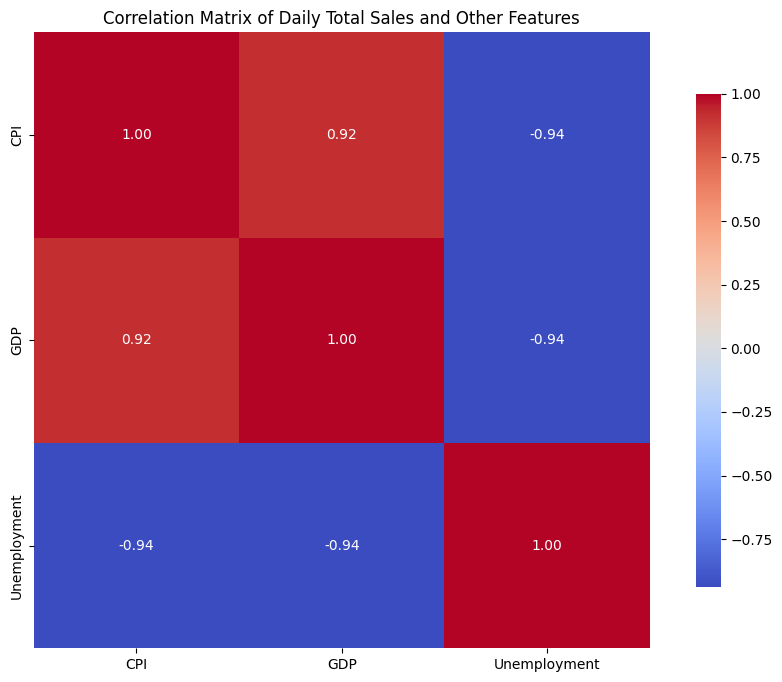

In [57]:
correlation_columns = [ 'CPI', 'GDP', 'Unemployment']
correlation_matrix = df_2[correlation_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Daily Total Sales and Other Features')
plt.show()

In [60]:
# Fit the linear regression model
model = smf.ols('Umsatz ~  Group_brotchen + Group_croissant + Group_konditorei + Group_kuchen + Group_saisonbrot + CPI', data=df_encode).fit()

# Modellzusammenfassung ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     32.52
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           5.51e-39
Time:                        13:54:18   Log-Likelihood:                -59571.
No. Observations:                9334   AIC:                         1.192e+05
Df Residuals:                    9327   BIC:                         1.192e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# 3 Feature Preparation
For the final training dataframe, we need to replace all strings with numerical data. There are two main approaches to achieve this:

### 3.1 Encoding
#### Label Encoding
Each category gets a label, e.g., cold = 0, cool = 1, etc.  
For this approach, it is important that the data is continuous, meaning the labeled categories have a fixed relationship to each other.  
For example: cold < cool < mild < warm, 0 < 1 < 2 < 3

#### One-Hot Encoding
For non-continuous data like the weather code, one-hot encoding is more suitable. In this approach, each category gets its own column, filled with 1 or 0 depending on whether the category applies or not.


In [95]:

# Kopiere DataFrame zur Bearbeitung
feature_encoded = feature_collection.copy()

# Label Encoding für ordinale Kategorien
label_encoders = {}
for col in ["Temperatureclass", "Cloudclass", "Windclass"]:
    le = LabelEncoder()
    feature_collection[col + "_enc"] = le.fit_transform(feature_encoded[col])
    label_encoders[col] = le  # falls später wieder dekodiert werden soll

# One-Hot Encoding für nicht-ordinale Kategorie
feature_encoded = pd.get_dummies(feature_collection, columns=["Weathercategorie"], prefix="Weather")
feature_encoded

,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Temperatureclass,Cloudclass,Windclass,Wochentag,Wochenende,Monat,Schulferien,Temperatureclass_enc,Cloudclass_enc,Windclass_enc,Weather_After Rain,Weather_Fog,Weather_Other,Weather_Rain,Weather_Showers and Thunderstorms,Weather_Snow and Ice
0,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,mild,sunny,wind,0,0,7,1,3,2,3,1,0,0,0,0,0
1,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0,mild,sunny,wind,1,0,7,1,3,2,3,0,0,1,0,0,0
2,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,mild,cloudy,breeze,2,0,7,1,3,1,1,0,0,0,1,0,0
3,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,mild,cloudy,breeze,3,0,7,1,3,1,1,1,0,0,0,0,0
4,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0,mild,sunny,wind,4,0,7,1,3,2,3,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0,cold,cloudy,breeze,5,1,12,1,1,1,1,0,0,1,0,0,0
11160,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0,cool,cloudy,breeze,6,1,12,1,2,1,1,0,0,0,1,0,0
11161,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0,cold,cloudy,wind,0,0,12,1,1,1,3,1,0,0,0,0,0
11162,2018-12-27,6,NaN,7.0,7.1250,12.0,20.0,0,cool,cloudy,wind,3,0,12,1,2,1,3,1,0,0,0,0,0


### 3.2 Clean Up
Drop all columns that schould not be in the trainings dataset. 

In [96]:
features = feature_encoded.copy()
features = features.drop(columns=[	'Temperatureclass',	'Cloudclass',	'Windclass'])
pd.set_option('display.max_columns', None)
features

,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Wochentag,Wochenende,Monat,Schulferien,Temperatureclass_enc,Cloudclass_enc,Windclass_enc,Weather_After Rain,Weather_Fog,Weather_Other,Weather_Rain,Weather_Showers and Thunderstorms,Weather_Snow and Ice
0,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,0,0,7,1,3,2,3,1,0,0,0,0,0
1,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0,1,0,7,1,3,2,3,0,0,1,0,0,0
2,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,2,0,7,1,3,1,1,0,0,0,1,0,0
3,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,3,0,7,1,3,1,1,1,0,0,0,0,0
4,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0,4,0,7,1,3,2,3,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,2018-12-22,6,NaN,8.0,4.3000,4.0,NaN,0,5,1,12,1,1,1,1,0,0,1,0,0,0
11160,2018-12-23,6,NaN,7.0,6.4500,9.0,61.0,0,6,1,12,1,2,1,1,0,0,0,1,0,0
11161,2018-12-24,6,NaN,7.0,2.5000,10.0,22.0,0,0,0,12,1,1,1,3,1,0,0,0,0,0
11162,2018-12-27,6,NaN,7.0,7.1250,12.0,20.0,0,3,0,12,1,2,1,3,1,0,0,0,0,0


# 4 Time Split
We Split the dataset into training, validation and test data


In [97]:
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'


train_data = features[features['Datum']<=train_end_date]
vali_data = features[(features['Datum']> train_end_date) & (features['Datum']<=validation_end_date)]
test_data = features[(features['Datum']> validation_end_date)]

# 5 Simple Linear Regression Model

In this simple test model, I fit the sales to a combination of product group and day of the week.

### 5.1 Create a model with the train_data

In [98]:
# Fit the linear regression model
model = smf.ols('Umsatz ~ Warengruppe + Wochentag', data=train_data).fit()

# Modellzusammenfassung ausgeben
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     83.29
Date:                Sat, 24 May 2025   Prob (F-statistic):           1.67e-36
Time:                        01:43:57   Log-Likelihood:                -47982.
No. Observations:                7493   AIC:                         9.597e+04
Df Residuals:                    7490   BIC:                         9.599e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     198.0404      4.629     42.780      

### 5.3 Predict the Sales of the test_data


In [99]:
pred = model.predict(test_data)
pred

9334     211.946204
9335     221.880669
9336     231.815134
9337     241.749599
9338     251.684063
            ...    
11159    211.933919
11160    221.868383
11161    162.261595
11162    192.064989
11163    201.999454
Length: 1830, dtype: float64

### 5.4 CSV output for kaggel



In [100]:
pred_df = pred.rename("Umsatz").reset_index()
pred_df.to_csv("prognose_kaggle.csv", index=False)